## Question 1. ZLG algorithm implementation (50 points)
**You are to implement the ZLG algorithm for this problem.**
- **We will use a subset of multiclass data where the label is a protein subcellular localization.**
- **The 8 features are extracted from the protein sequence.**
- **For this problem we are only using points with labels `MIT` or `NUC`.**
- **A total of 673 data points have labels `MIT` or `NUC`. We start with the labels of only the first 200 data points (set `Y_k`). The other 473 points are in `Y_u`.**


# 1.0. Part 0. (15 points)
**First, read the paper and answer the following questions.**
### 1. What is the idea behind the ZLG algorithm (5 points)?

#### Formal Version
ZLG is a Type II active learning algorithm used for binary classification on a pool-based data access model. It 
labels instances based on expected risk, and it comes with no guarantees of performance or label complexity.

The algorithm starts by building a weighted graph over a pool of labeled and unlabeled instances, with edges connecting 
instances which are deemed "similar enough." ZLG uses the graph and known labels to construct a probability 
distribution over the unlabeled instances. It finds the optimal labeling solution for the distribution in closed-form,
producing label predictions for all unlabeled instances.

ZLG uses these predictions to calculate the expected risk of inferring labels for all unlabeled instances.
The algorithm searches through the unlabeled 
instances to find the one which, when labeled, reduces the expected risk the most. ZLG queries the label for this instance and updates label
predictions for all unlabeled instances based on the label. This search process is 
repeated until a defined stopping point, at which point we use the current label predictions to label all unlabeled 
instances.

#### Informal Version
*In layman's terms, ZLG starts with the idea that if we assume data has natural clusters, we can also assume that 
two data points which are close together are likely to have the same label. Under this theory, labeled instances 
surrounding an unlabeled instance "influence" what the label ought to be, with the amount of influence depending on 
how similar a labeled instance is to the unlabeled one.* 

*ZLG models this influence as a system of energy, with each data point radiating energy outward onto all of its 
neighbors. Data points with similar labels "vibrate" at similar wavelengths, creating resonance; data points 
with different labels vibrate at different wavelengths, creating dissonance. By considering the energies of all 
of the points, we can determine the energy of the overall system. ZLG leverages the well-studied principles of a system of energy (Boltzmann distribution) to efficiently estimate a 
labeling which produces a system with the least energy (i.e. least dissonance), given the current set of labeled instances. The estimates represents what the labels should be when considered as a system of energy.*

*Given that this is an estimate, there is some risk that the predicted labels are wrong. Until its query budget is used up, ZLG repeatedly searches for the best instances to query to minimize this risk, updating its predictions along the way.*




### 2. What are the assumptions behind the ZLG algorithm (5 points)?
- ZLG assumes that a Radial Basis Function provides a good measurement of the similarity between data points.
- ZLG assumes that the labels follow a Boltzmann distribution
- ZLG assumes that inferred labelings, given the labeled data, follow a Multivariate Gaussian distribution
- ZLG assumes that expected risk is the best strategy for selecting points to label
- ZLG assumes that all of the features have equal importance when calculating similarity
- ZLG assumes we have a pool of data.
- ZLG assumes we have binary labels.


### 3. What are the pros and cons of the ZLG algorithm (5 points)?
#### Pros
- ZLG allows for very efficient label estimates and decisions for which points to label.
- ZLG uses well-known techniques like the Laplacian matrix, which helps with comprehension of the algorithm and what it is doing.
- ZLG uses expected risk as the query selection strategy, which is a more rigorous method than uncertainty.


#### Cons
- ZLG does not come with performance or label complexity guarantees.
- ZLG makes a number of assumptions about the relationship of the labels to the data points, for mathematical convenience. If those assumptions do not hold, then the model may not perform well.
- A lot of importance is put on accurately representing the similarity of two data points. If certain features of data points are more important than others, ZLG does not take this into account when calculating weights. This could lead to a less performant model overall.


### Imports

In [1]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder

import packages.zlg.zlg as zlg

### Data Prep

In [2]:
data = pd.read_csv('data/data.csv')
print('shape',data.shape)
print('unique labels', data.Label.unique())
data.head(5)

shape (673, 9)
unique labels ['MIT' 'NUC']


,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
# filter out records without desired labels
data_MITNUC = data.loc[data['Label'].isin(['MIT','NUC'])].values

# split data into features and target, encode target classes as 0 or 1
X = data_MITNUC[:,:8]
y = LabelEncoder().fit_transform(data_MITNUC[:,-1])

print(X.shape)
print(y.shape)

(673, 8)
(673,)


In [4]:
# split data into first 200 records and remainder
n_l = 200

Xk = X[:n_l,:]
Yk = y[:n_l]
Xu = X[n_l:,:]
Yu = y[n_l:]

print(Xk.shape)
print(Yk.shape)
print(Xu.shape)
print(Yu.shape)

(200, 8)
(200,)
(473, 8)
(473,)


# 1.1. Part 1 (5 points)
**TODO:**
- **Let's first construct the weight matrix W.**
- **Use $t = 0$ and $\sigma$ as the standard deviation of $X$.**
- **Calculate the $D$ matrix and the Laplacian matrix (Delta) for use in other parts.**

#### Radial basis function (RBF):
Calculates similarity between points $x_i$ and $x_j$ using squared Euclidean distance.

$$w_{ij}=\exp{\left( -\frac{1}{\sigma^2}\sum_{d=1}^m (x_{id} - x_{jd})^2 \right)}$$

In [5]:
# laplacian_matrix() implemented in custom Python package zlg
# calculations are performed in Part 5

# 1.2. Part 2 (5 points) 
**TODO:**
- **Now complete the subroutine to compute the minimum-energy solution for the unlabeled instances.**
    - **Hint: Use the formula in page 38, Lecture 7.** 
- **The function also outputs one submatrix that we will use to select points to query.**

#### Minimum energy solution $f_u$

$$f_u = -\Delta_{uu}^{-1}\Delta_{ul}f_l$$

In [6]:
# minimum_energy_solution() implemented in custom Python package zlg

# 1.3. Part 3 (15 points) 
**TODO:**
- **We would like to query the points that minimize the expected risk. To do so, we want to be able to calculate the expected estimated risk after querying any point $k$.**
- **The variable `Rhat_fplus_xk` refers to $\hat{R}(f^{+x_k})$.**
- **`fu_xk0` is $f_u^{+(x_k,0)}$ and vice versa for `fu_xk1`.**

#### Expected risk:

$$\hat{R}\left( f^{+(x_k,y_k)} \right)=\sum_{i=1}^n min\left( f_i^{+(x_k,y_k)},1-f_i^{+(x_k,y_k)}\right)$$

where 
- $f^{+(x_k,y_k)}$ is a n x 1 vector of the updated minimum energy solution for n unlabeled points if point $k$ was labeled
- $f_i^{+(x_k,y_k)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled

***

#### Expected estimated risk:

$$\hat{R}\left( f^{+x_k} \right)=
(1-f_k)\hat{R}\left( f^{+(x_k,0)} \right)
+   f_k\hat{R}\left( f^{+(x_k,1)} \right)$$

where
- $f_i^{+(x_k,0)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled with $y_k=0$
- $f_i^{+(x_k,1)}$ is the updated minimum energy solution of the ith unlabeled point if point $k$ was labeled with $y_k=1$
- $f_k$ is the current minimum energy solution of the kth unlabeled point


***

#### Conditional Distribution of all unlabeled nodes:

$$f_u^{+(x_k,y_k)}=f_u+(y_k-f_k)\frac{(\Delta_{uu}^{-1})_{ \cdot k}}{(\Delta_{uu}^{-1})_{kk}}$$

where
- $f_u$ is the updated minimum energy solution of unlabeled points if instance $x_k$ was labeled with $y_k$
- $f_k$ is the current minimum energy solution of the kth unlabeled point
- $\Delta_{uu_{. k}}^{-1}$ is the kth column of the inverse Laplacian on unlabeled data
- $\Delta_{uu_{kk}}^{-1}$ is the kth diagonal element of the same matrix


In [7]:
# expected_estimated_risk() implemented in custom Python package zlg

# 1.4. Part 4 (5 points) 
**TODO:**
- **Compute the above expected estimated risk for all unlabeled points and select one to query.**

In [8]:
# zlg_query() implemented in custom Python package zlg
# selection occurs in Part 5

# 1.5. Part 5
**TODO:**
- **Let's try querying 100 points. Which points are queried?** 
- **Compare with random queries and make a plot.**

In [9]:
def score_model(f_u, y_true):
    y_pred = np.round(f_u)
    
    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError('Arrays must be the same size to compare.')
    
    wrong = (y_pred != y_true).sum()
    error = wrong / len(y_true)
    return 1.0 - error


print('test score_model()')
a = np.array([0.51,0.7,0.1,0.2])
b = np.array([1,0,0,0])
assert score_model(a,b) == 3/4, score_model(a,b)

test score_model()


In [10]:
def plot_accuracy(accuracy):
    plt.xlabel('Number of queries')
    plt.ylabel('Accuracy')
    plt.title('Number of queries vs Accuracy')
    plt.plot(accuracy)
    plt.show()

### ZLG Query

In [11]:
%%time 
# 2 min

# copy data for use in this section
Xk_zlg = copy.deepcopy(Xk)
Yk_zlg = copy.deepcopy(Yk)
Xu_zlg = copy.deepcopy(Xu)
Yu_zlg = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_zlg.shape[0]
labeled_zlg = [i for i in range(200)]
unlabeled_zlg = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg,unlabeled_zlg,Yk)


# run required iterations
queried_zlg = []
scores_zlg = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = zlg.zlg_query(fu, Delta_uu_inv,n_l,n_samples)
    queried_zlg.append(query_idx)
    
    # add instance to labeled set
    Yk_zlg = np.append(Yk_zlg,Yu_zlg[query_idx])
    Xk_zlg = np.append(Xk_zlg,[Xu_zlg[query_idx,:]],axis=0)
    n_l += 1
    labeled_zlg.append(unlabeled_zlg.pop(0))  # move first element in unlabeled to end of labeled list
    
    # remove instance from unlabeled set
    Yu_zlg = np.delete(Yu_zlg,query_idx)
    Xu_zlg = np.delete(Xu_zlg,query_idx, 0)
    
    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_zlg,Xu_zlg),axis=0), t=0)
    
    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg, unlabeled_zlg,Yk_zlg)
    
    # score model by testing on all unlabeled points left at each step
    scores_zlg.append(score_model(fu, Yu_zlg))

CPU times: user 2min 24s, sys: 1.35 s, total: 2min 25s
Wall time: 1min 26s


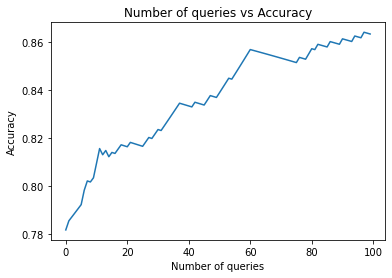

Highest accuracy: 0.864


In [12]:
plot_accuracy(scores_zlg)
print('Highest accuracy:', max(scores_zlg))

In [23]:
print('List of queried points relative to unlabeled set for that round')
print(queried_zlg)

List of queried points relative to unlabeled set for that round
[115, 123, 228, 178, 16, 130, 388, 41, 74, 101, 345, 89, 223, 244, 379, 226, 146, 85, 97, 311, 261, 86, 147, 380, 151, 215, 91, 74, 198, 114, 83, 235, 88, 78, 118, 187, 105, 7, 56, 333, 378, 93, 202, 134, 264, 153, 81, 69, 224, 134, 266, 73, 83, 72, 52, 383, 149, 76, 62, 383, 75, 87, 385, 232, 49, 231, 134, 145, 252, 140, 104, 232, 43, 22, 373, 54, 141, 237, 193, 88, 70, 17, 11, 253, 97, 190, 258, 42, 151, 44, 116, 285, 57, 90, 123, 126, 255, 164, 125, 124]


### Version implemented as ZLG class
This method introduces some changes upon the above method.
- Moves the process of performing and scoring multiple queries into a class.
- Tracks index of queried samples relative to original X, not the current unlabeled set. (See Note 1 inside zlg.py)
- Maintains set of predicted labels internally, accessible at any time.

In [14]:
%%time
# 2 min

# copy data for use in this section
Xk_zlg2 = copy.deepcopy(Xk)
Yk_zlg2 = copy.deepcopy(Yk)
Xu_zlg2 = copy.deepcopy(Xu)
Yu_zlg2 = copy.deepcopy(Yu)

model = zlg.ZLG(Xk_zlg2,Yk_zlg2,Xu_zlg2,Yu_zlg2)
queried_zlg2, scores_zlg2 = model.improve_predictions(t=0,budget=100)

CPU times: user 2min 22s, sys: 1.21 s, total: 2min 23s
Wall time: 1min 24s


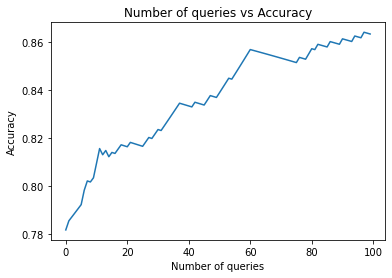

Highest accuracy: 0.864


In [15]:
plot_accuracy(scores_zlg2)
print('Highest accuracy:', max(scores_zlg2))

In [16]:
print('List of queried points relative to original X')
print(queried_zlg2)

List of queried points relative to original X
[315, 324, 430, 380, 216, 333, 594, 242, 276, 304, 554, 292, 433, 455, 592, 437, 354, 288, 302, 527, 477, 290, 359, 603, 364, 431, 297, 277, 415, 326, 287, 460, 296, 282, 335, 409, 319, 207, 259, 569, 618, 308, 432, 357, 501, 379, 291, 273, 463, 361, 509, 280, 299, 279, 255, 638, 384, 289, 267, 642, 293, 312, 647, 483, 252, 484, 372, 387, 510, 381, 337, 490, 246, 224, 646, 262, 389, 500, 449, 320, 286, 219, 212, 525, 338, 452, 534, 249, 406, 253, 365, 567, 271, 331, 376, 383, 540, 428, 382, 378]


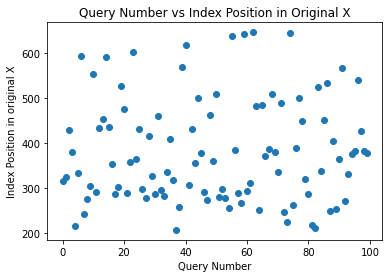

In [25]:
# visualize where queries were made within sample space
plt.scatter(np.arange(100),queried_zlg2)
plt.xlabel('Query Number')
plt.ylabel('Index Position in original X')
plt.title('Query Number vs Index Position in Original X')
plt.show()

### Random Query

In [19]:
%%time
# 2 min

# copy data for use in this section
Xk_rand = copy.deepcopy(Xk)
Yk_rand = copy.deepcopy(Yk)
Xu_rand = copy.deepcopy(Xu)
Yu_rand = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_rand.shape[0]
labeled_rand = [i for i in range(200)]
unlabeled_rand = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand,unlabeled_rand,Yk)


# run required iterations
queried_rand = []
scores_rand = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = np.random.randint(low=0,high=len(unlabeled_rand),size=1)[0] # random unlabeled point
    queried_rand.append(query_idx)

    # add instance to labeled set
    Yk_rand = np.append(Yk_rand,Yu_rand[query_idx])
    Xk_rand = np.append(Xk_rand,[Xu_rand[query_idx,:]],axis=0)
    n_l += 1
    labeled_rand.append(unlabeled_rand.pop(0))  # move first element in unlabeled to end of labeled list

    # remove instance from unlabeled set
    Yu_rand = np.delete(Yu_rand,query_idx)
    Xu_rand = np.delete(Xu_rand,query_idx, 0)

    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_rand,Xu_rand),axis=0), t=0)

    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand, unlabeled_rand,Yk_rand)

    # score model by testing on all unlabeled points left at each step
    scores_rand.append(score_model(fu, Yu_rand))

CPU times: user 1min 53s, sys: 812 ms, total: 1min 54s
Wall time: 54.6 s


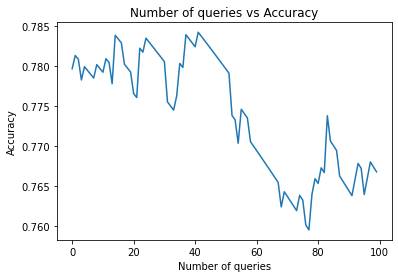

Highest accuracy: 0.7842227378190255


In [20]:
plot_accuracy(scores_rand)
print('Highest accuracy:', max(scores_rand))

In [21]:
print('List of queried points relative to unlabeled set for that round')
print(queried_rand)

List of queried points relative to unlabeled set for that round
[361, 12, 249, 223, 114, 322, 175, 199, 107, 57, 214, 457, 364, 411, 71, 359, 148, 252, 255, 194, 207, 219, 77, 370, 311, 188, 292, 43, 65, 195, 108, 251, 356, 10, 77, 1, 302, 90, 399, 384, 424, 7, 134, 223, 332, 185, 150, 418, 49, 238, 121, 268, 288, 299, 19, 390, 187, 297, 101, 306, 276, 221, 32, 191, 155, 217, 184, 249, 119, 158, 213, 130, 362, 62, 381, 163, 219, 318, 195, 66, 331, 1, 251, 154, 255, 213, 148, 49, 349, 363, 117, 199, 256, 64, 197, 357, 114, 87, 291, 51]


### Comparison

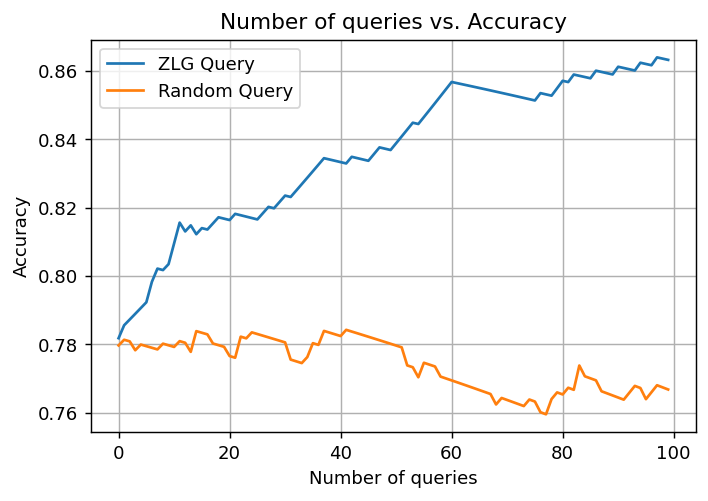

In [22]:
# plot both together
fig, ax = plt.subplots(dpi=130)
ax.plot(scores_zlg, label='ZLG Query')
ax.plot(scores_rand,label='Random Query')
plt.xlabel('Number of queries')
plt.ylabel('Accuracy')
plt.title('Number of queries vs. Accuracy')
plt.grid()
plt.legend()       
plt.show()

# 1.6. Bonus question 

**Answer the following questions. (Your grade will not exceed 100 for this homework.)**

#### 1. For this dataset, how many labeled data points do you actually need to train the model sufficiently well? 
#### 2. And why?